In [1]:
import pystac
import rioxarray

### Load Data

In [11]:
# load image & inspect the shape
items = pystac.ItemCollection.from_file("geospatial-python-raster-dataset/search.json")
# items[1]
items[1].assets # look for true color image (VISUAL key)
visual_href = items[1].assets["visual"].href
raster = rioxarray.open_rasterio(visual_href) # performs lazy loading# g
raster.shape

(3, 10980, 10980)

In [14]:
# get overview asset
overview_href = visual_href.replace("visual", "overview") # this is a correction to the tutorial
raster_overview = rioxarray.open_rasterio(overview_href, overview_level=3)
raster_overview.shape

(3, 687, 687)

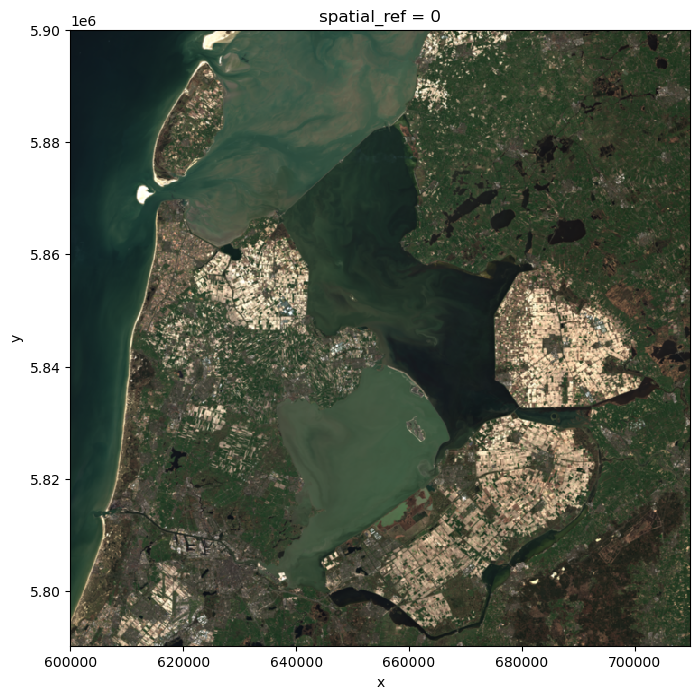

In [15]:
raster_overview.plot.imshow(figsize=(8,8))

### Compare and align coordinate systems

In [16]:
from pyproj import CRS

# check the coordinate system
CRS(raster.rio.crs)

<Projected CRS: EPSG:32631>
Name: WGS 84 / UTM zone 31N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
import geopandas as gpd

# load the polygons of the crop fields
fields = gpd.read_file("data_export_vector/fields_cropped.shp")

# check the coordinate system
fields.crs

<Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Coordinate Operation:
- name: RD New
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [18]:
# convert shp to raster crs (in this case, to optimize for speed - the shp < raster)
fields = fields.to_crs(raster.rio.crs)

### Crop the raster data with bbox

In [22]:
raster_clip_box = raster.rio.clip_box(*fields.total_bounds)
raster_clip_box.shape

(3, 1574, 1584)

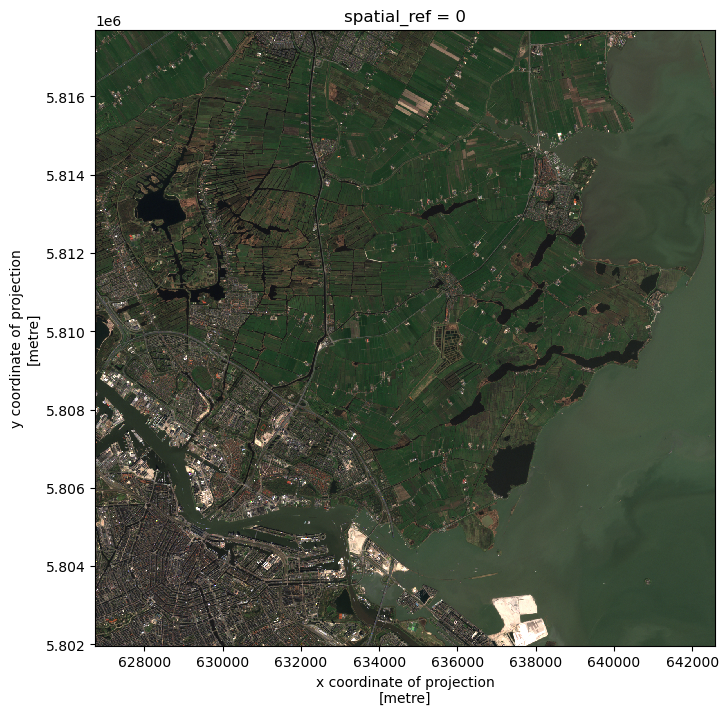

In [23]:
# visualize the clipped raster
raster_clip_box.plot.imshow(figsize=(8,8))

In [24]:
# save clipped raster for later use
raster_clip_box.rio.to_raster("data_export_raster/raster_clip.tif")

### Crop raster with (CLIP TO) polygon

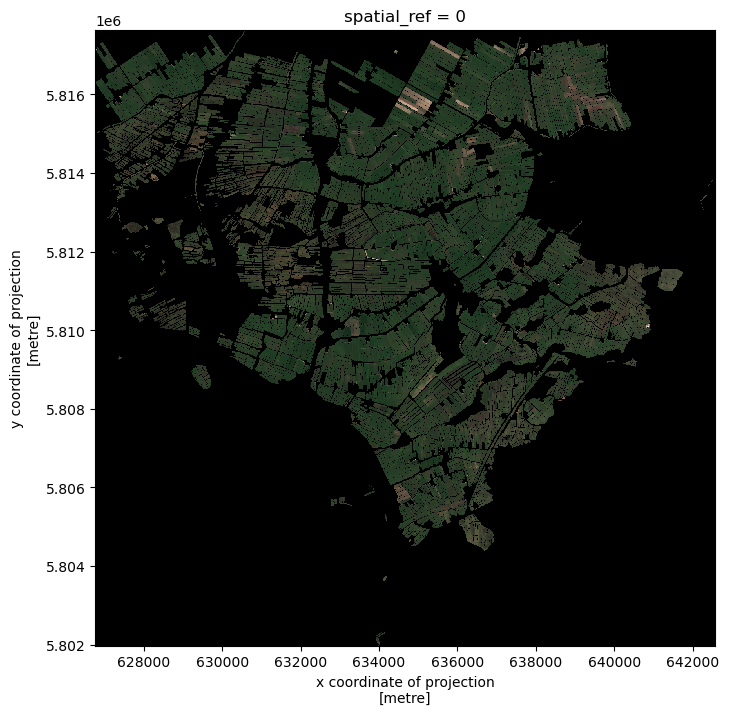

In [26]:
raster_clipped_to_fields = raster_clip_box.rio.clip(fields['geometry'])
raster_clipped_to_fields.plot.imshow(figsize=(8,8))

### Crop to selected field polygons

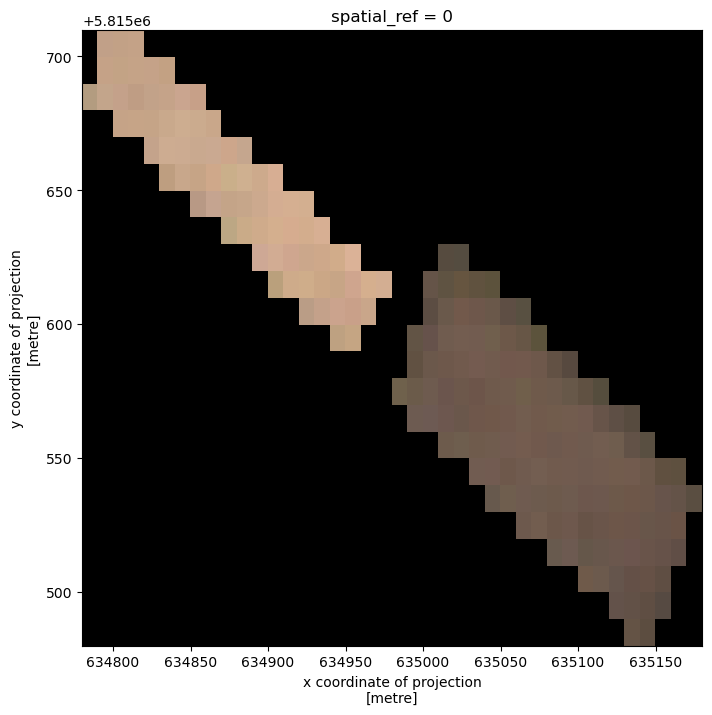

In [29]:
selection = fields['gewascode']==257 # selection = mask (filter)
selected_fields = fields.where(selection)
selected_fields = selected_fields.dropna()
raster_clipped_to_selected_fields = raster_clip_box.rio.clip(selected_fields['geometry'])
raster_clipped_to_selected_fields.plot.imshow(figsize=(8,8))

### Crop raster using reproject_match() function

In [32]:
# Reproject to RD to make the CRS different from the "raster"
reprojected_raster = raster_clipped_to_selected_fields.rio.reproject("EPSG:28992")
CRS(reprojected_raster.rio.crs)

<Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [34]:
CRS(raster_clip_box.rio.crs)

<Projected CRS: EPSG:32631>
Name: WGS 84 / UTM zone 31N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

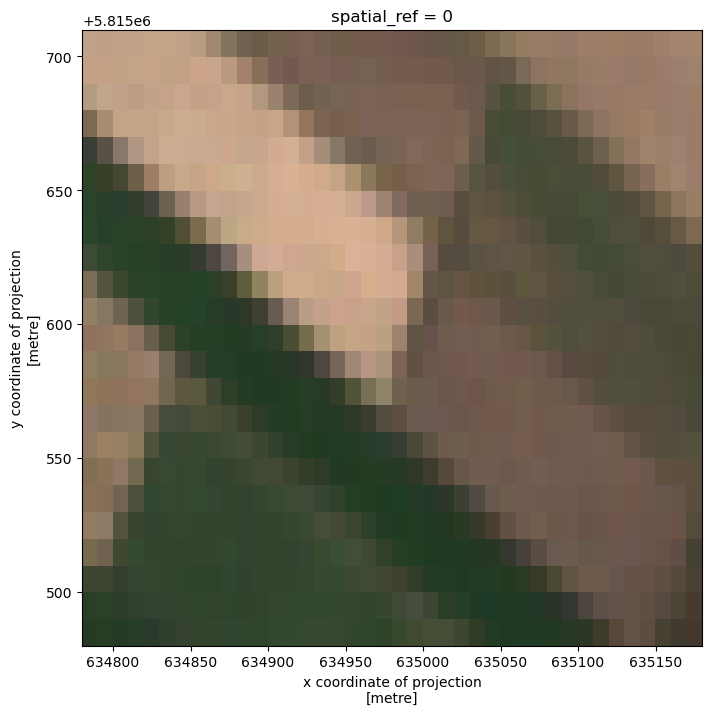

In [35]:
raster_reproject_match = raster_clip_box.rio.reproject_match(raster_clipped_to_selected_fields)
raster_reproject_match.plot.imshow(figsize=(8,8))

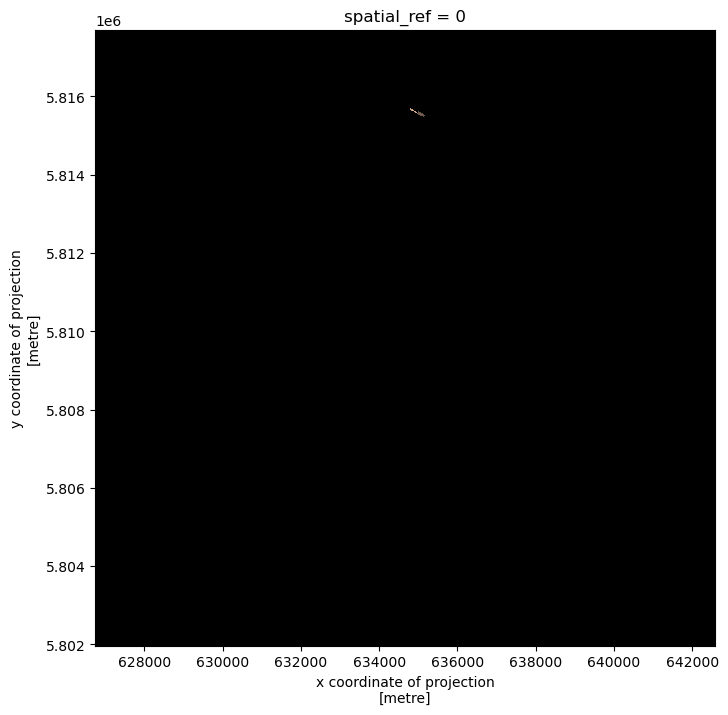

In [36]:
### expand raster clipped to selected fields back up to the extent of raster_clip_box
raster_reproject_match_2 = raster_clipped_to_selected_fields.rio.reproject_match(raster_clip_box)
raster_reproject_match_2.plot.imshow(figsize=(8,8))